In [40]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt

In [41]:
BASE_PATH = "/kaggle/input/data-science-bowl-2018-competition-merged-mask"
DATASET_PATH = os.path.join(BASE_PATH, "data science bowl 2018", "stage1_train 2")
print("Total samples:", len(os.listdir(DATASET_PATH)))

Total samples: 670


In [42]:
def build_merged_mask(mask_dir, shape):
    merged = np.zeros(shape, dtype=np.uint8)
    for file in os.listdir(mask_dir):
        r = cv2.imread(os.path.join(mask_dir, file), 0)
        if r is not None:
            merged = np.maximum(merged, r)
    return (merged > 0).astype(np.uint8)


In [43]:
def watershed_no_markers(distance, mask):
    labels = watershed(-distance, mask=mask)
    return labels
    
def watershed_with_markers(distance, mask, min_distance):
    coords = peak_local_max(distance,
                            min_distance=min_distance,
                            labels=mask)
    markers = np.zeros(distance.shape, dtype=int)
    for i, (r, c) in enumerate(coords):
        markers[r, c] = i + 1

    labels = watershed(-distance, markers, mask=mask)
    return labels


Ground truth nuclei: 10
min_distance=2: nuclei=11
min_distance=3: nuclei=10
min_distance=5: nuclei=9
min_distance=8: nuclei=9
min_distance=10: nuclei=9
min_distance=12: nuclei=8
min_distance=15: nuclei=7


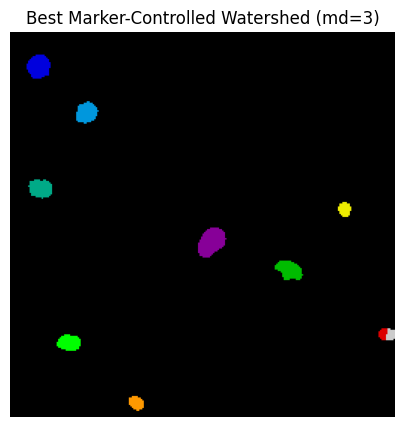

Best min_distance: 3
Predicted nuclei: 10
GT nuclei: 10


In [44]:
sample_folder = os.listdir(DATASET_PATH)[0]

img_dir = os.path.join(DATASET_PATH, sample_folder, "images")
mask_dir = os.path.join(DATASET_PATH, sample_folder, "masks")

img_name = os.listdir(img_dir)[0]
image = cv2.imread(os.path.join(img_dir, img_name), 0)

merged_mask = build_merged_mask(mask_dir, image.shape)
gt_count = len(os.listdir(mask_dir))

distance = cv2.distanceTransform(merged_mask, cv2.DIST_L2, 5)

marker_distances = [2, 3, 5, 8, 10, 12, 15]

best_md = None
best_labels = None

print("Ground truth nuclei:", gt_count)

for md in marker_distances:
    labels = watershed_with_markers(distance, merged_mask, md)
    
    nuclei_count = len(np.unique(labels)) - 1
    print(f"min_distance={md}: nuclei={nuclei_count}")
    
    if best_md is None or abs(nuclei_count - gt_count) < abs((len(np.unique(best_labels))-1) - gt_count):
        best_md = md
        best_labels = labels

plt.figure(figsize=(5,5))
plt.title(f"Best Marker-Controlled Watershed (md={best_md})")
plt.imshow(best_labels, cmap="nipy_spectral")
plt.axis("off")
plt.show()

print("Best min_distance:", best_md)
print("Predicted nuclei:", len(np.unique(best_labels)) - 1)
print("GT nuclei:", gt_count)


Image 1
Ground Truth Nuclei: 10
Naive Watershed Count: 13
Best min_distance: 3
Marker Watershed Count: 10


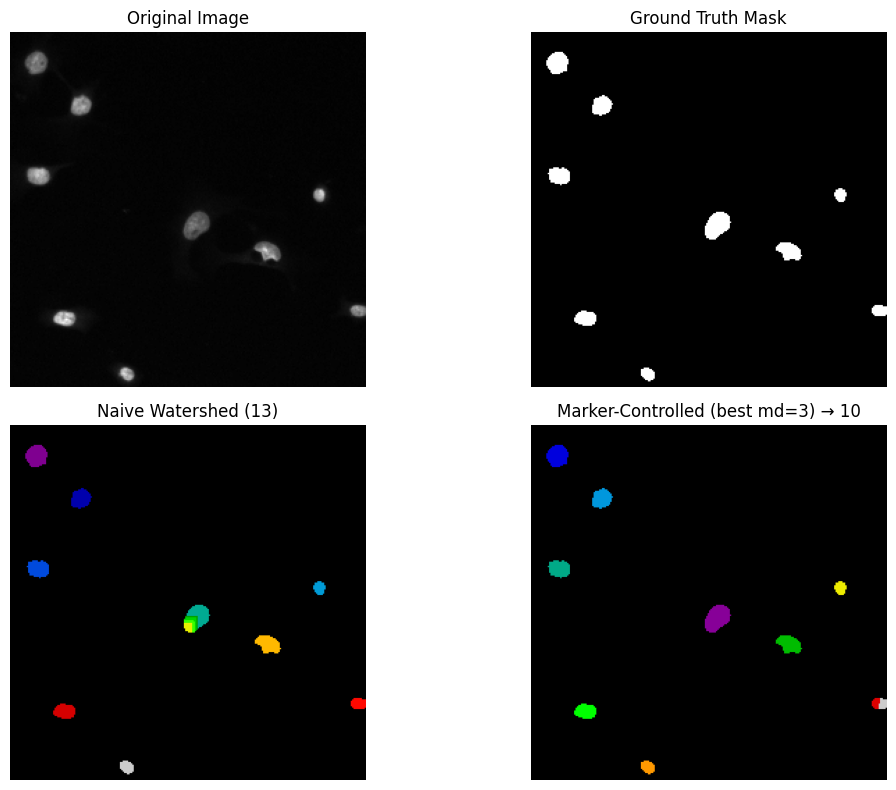


Image 2
Ground Truth Nuclei: 24
Naive Watershed Count: 31
Best min_distance: 3
Marker Watershed Count: 25


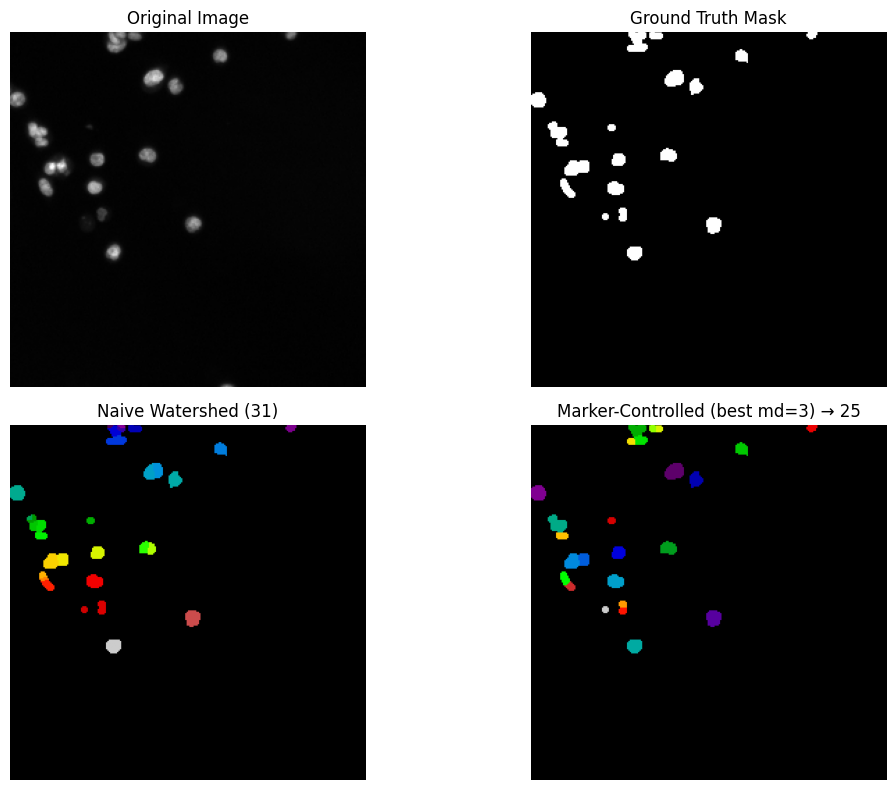


Image 3
Ground Truth Nuclei: 10
Naive Watershed Count: 13
Best min_distance: 3
Marker Watershed Count: 10


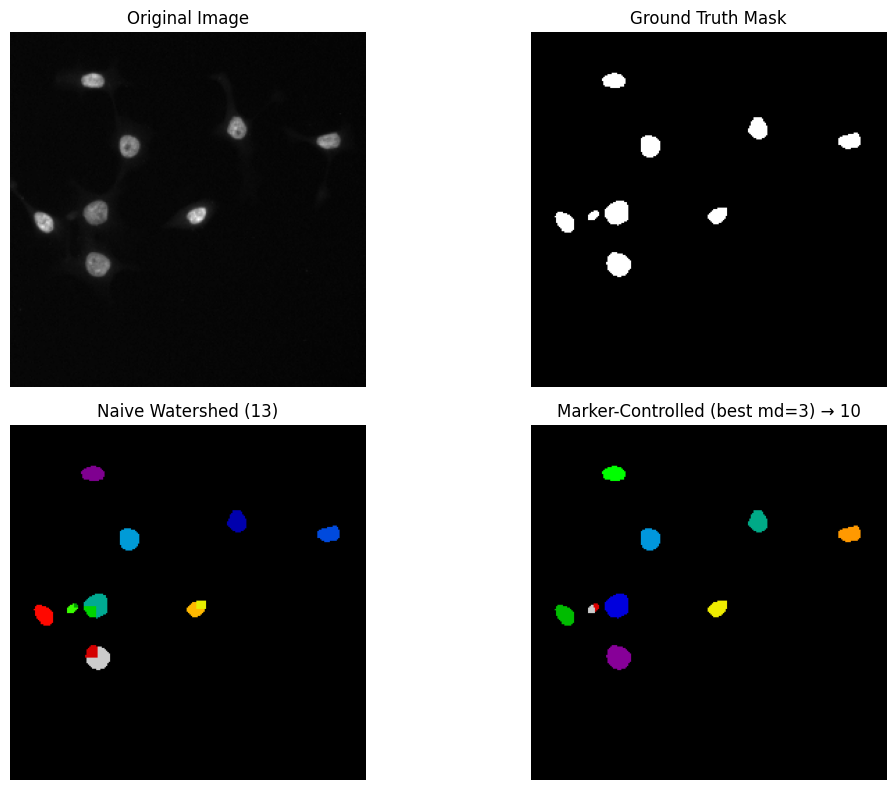


Image 4
Ground Truth Nuclei: 5
Naive Watershed Count: 6
Best min_distance: 2
Marker Watershed Count: 4


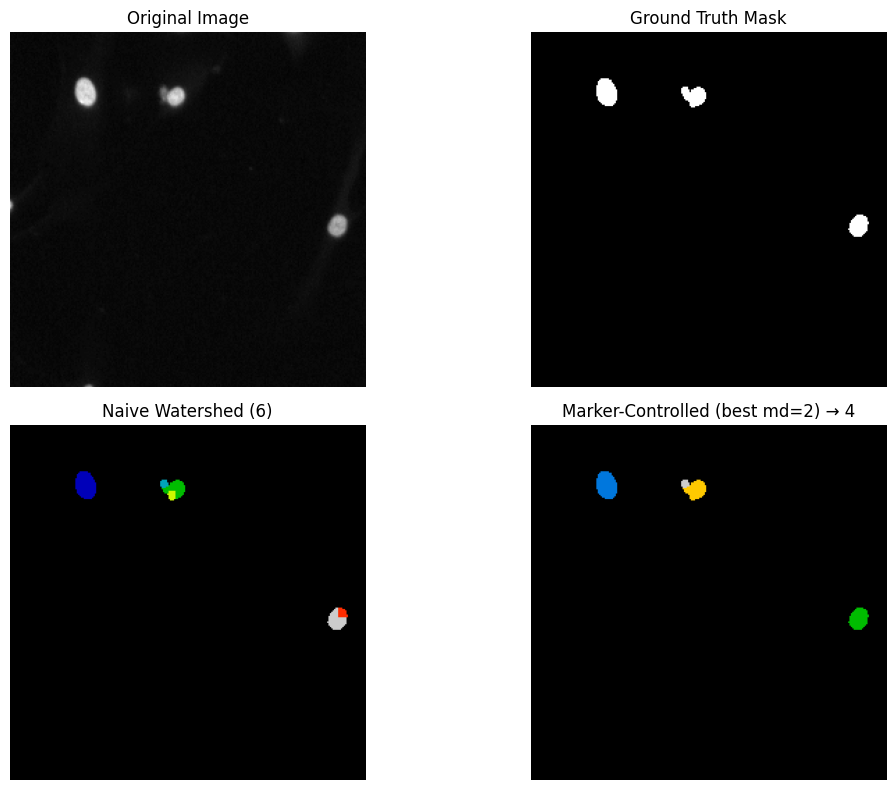


Image 5
Ground Truth Nuclei: 13
Naive Watershed Count: 17
Best min_distance: 3
Marker Watershed Count: 13


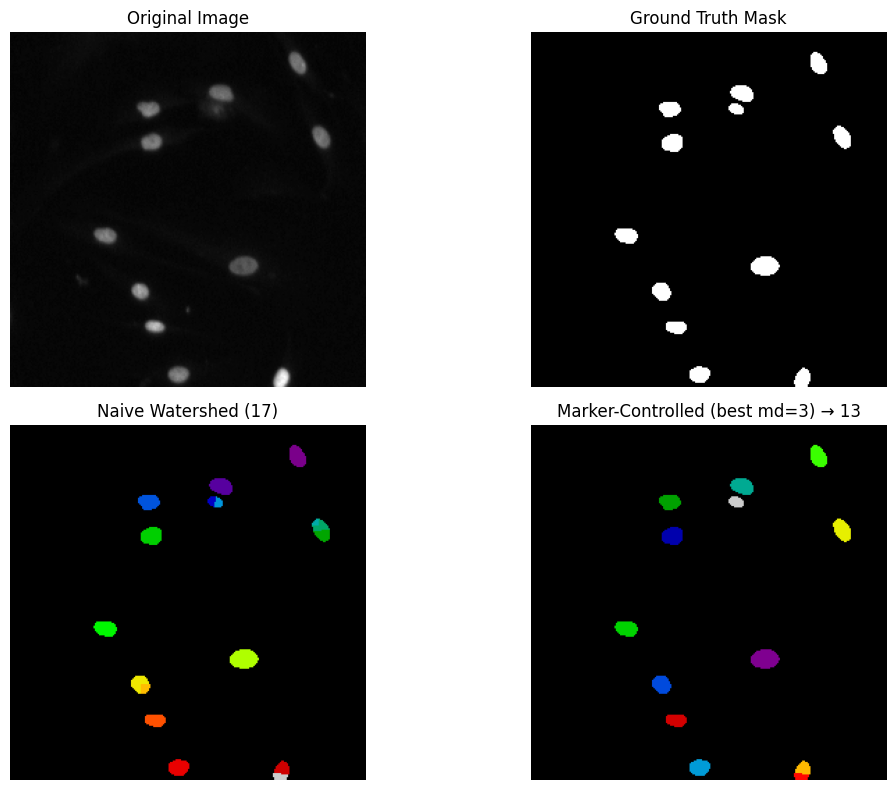

In [45]:
MAX_IMAGES = 5
count = 0

marker_distances = [2, 3, 5, 8, 10, 12, 15]   
for folder in os.listdir(DATASET_PATH):

    if count >= MAX_IMAGES:
        break

    sample_path = os.path.join(DATASET_PATH, folder)
    img_dir = os.path.join(sample_path, "images")
    mask_dir = os.path.join(sample_path, "masks")

    img_file = os.listdir(img_dir)[0]
    image = cv2.imread(os.path.join(img_dir, img_file))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    merged_mask = build_merged_mask(mask_dir, gray.shape)
    gt_count = len(os.listdir(mask_dir))

    print(f"\nImage {count+1}")
    print("Ground Truth Nuclei:", gt_count)

    distance = distance_transform_edt(merged_mask)
    naive_labels = watershed_no_markers(distance, merged_mask)
    print("Naive Watershed Count:", naive_labels.max())

    best_md = None
    best_labels = None
    best_diff = float("inf")

    for md in marker_distances:
        labels = watershed_with_markers(distance, merged_mask, md)
        diff = abs((len(np.unique(labels)) - 1) - gt_count)

        if diff < best_diff:
            best_diff = diff
            best_md = md
            best_labels = labels

    print("Best min_distance:", best_md)
    print("Marker Watershed Count:", best_labels.max())

    plt.figure(figsize=(12,8))

    plt.subplot(2,2,1)
    plt.title("Original Image")
    plt.imshow(gray, cmap='gray')
    plt.axis("off")

    plt.subplot(2,2,2)
    plt.title("Ground Truth Mask")
    plt.imshow(merged_mask, cmap='gray')
    plt.axis("off")

    plt.subplot(2,2,3)
    plt.title(f"Naive Watershed ({naive_labels.max()})")
    plt.imshow(naive_labels, cmap='nipy_spectral')
    plt.axis("off")

    plt.subplot(2,2,4)
    plt.title(f"Marker-Controlled (best md={best_md}) → {best_labels.max()}")
    plt.imshow(best_labels, cmap='nipy_spectral')
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    count += 1